# Part 2: Decision Trees (60 points)

Decision trees are a popular approach to classification of discrete labels. They're interpretable -- the natural, graphical representation makes it simple for humans to understand the model and classify test instances, as well as straightforward to implement using basic information theoretic tools. 

In this part of the assignment, we'll cover the basics of computing the entropy, information gain, and information gain ratio used to generate decision trees. We'll see how decision trees work with both discrete and continuous features during prediction. Additionally, we'll consider regularization parameters such as the depth of the tree and maximum number of leaf nodes. We'll look briefly at regression trees and model trees. Finally, you'll build a decision tree classifier for a dataset of your choosing.


## Working with Categorical Attributes

With all the rain we've been having, mushrooms have been sprouting up all over the place! Perhaps you're entertaining the idea of going mushroom hunting. But, as we all know, many mushrooms are poisonous and can make you sick, or even die. And if you're dead, you won't be able to do Assignment 3, which would be really unfortunate. 

Lucky for you, we're going to look at a dataset that helps decide whether a mushroom is edible (e) or poisonous (p). You can read about the [mushroom dataset](http://archive.ics.uci.edu/ml/datasets/Mushroom) at the UCI Machine Learning dataset repository. The attributes include everything from the odor (almond? anise? foul? musty?) to the gill color (chocolate? purple? orange? gray?). You might be bewildered by the many potential attributes used to judge mushrooms, but we'll use decision trees to sort it all out.

As usual, we'll start by importing some Python modules and loading some data. One of the attributes has missing data, which I'm filling with the attribute "missing". The book has some detailed discussion of how to handle missing values using decision trees.

In [1]:
## Preliminaries

#Show plots in the notebook
%matplotlib inline

from sklearn import datasets, preprocessing, cross_validation, metrics, tree, ensemble, feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib2


#from sklearn.ensemble import RandomForestClassifier

In [2]:
#Load data
shroom_data = urllib2.urlopen("http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")
mushroom = pd.read_csv(shroom_data, quotechar='"', skipinitialspace=True, names=[ 'Class', 'CapShape', 'CapSurface', 'CapColor', 'Bruises', 'Odor', 'GillAttachment', 'GillSpacing', 'GillSize', 'GillColor', 'StalkShape', 'StalkRoot', 'StalkSurfaceAboveRing', 'StalkSurfaceBelowRing', 'StalkColorAboveRing', 'StalkColorBelowRing', 'VeilType', 'VeilColor', 'RingNumber', 'RingType', 'SporePrintColor', 'Population', 'Habitat'
 ], na_values="?")
mushroom = mushroom.fillna('missing')
#Separate the labels from the attributes
mushroom_labels = mushroom.loc[:,'Class']
mushroom_attrs = mushroom.iloc[:,1:]


## Question 1: Computing Information Measures for Categorical Data (20 points)
For this question, you'll need to compute entropy and information gain for attributes.
1.   Write a function to compute the entropy of a series of categorical data. What is the entropy of the labels (H(Class) for this dataset?
2.   Write a function to compute the entropy of the label given the a particular attribute setting (e.g. given a series for StalkRoot='b', compute H(Class|StalkRoot='b'). Apply this function to the GillColor attribute. Which GillColor has the lowest entropy? Which GillColor has the highest entropy? 
3.   Write a function that computes the entropy of the label conditioned on a label. What is the entropy H(Class|GillColor)?
4.   Write a function that computes the information gain of an attribute. Which attribute has the highest information gain? 

Now that you've gotten a sense of what's involved in choosing the attributes for a decision tree, we'll look at how to get scikit-learn to do that work for us.

<h1> Question 1 answers: </h1>

<p>1. Entropy of the labels is 99.91%</p>

<p>2. GillColor with lowest entropy -> b, r, o, e -> 0 entropy<br>
   GillColor with highest entropy -> p -> 0.985386661301
   
<p>3. GillColor entropy = 0.5820903734563292

<p>4. Odor has the highest information gain of 90.6%

In [3]:
# print mushroom_attrs
# print list(mushroom_labels.value_counts())
# print list(mushroom_labels[mushroom_attrs[mushroom_attrs['GillColor']=='p'].index].value_counts())
# print list(mushroom_attrs['GillColor'].value_counts().index)
# print list(mushroom_labels[mushroom_attrs[mushroom_attrs['GillColor']=='p'].index].value_counts())
# mushroom_labels.shape[0]

In [4]:
# Part 1 code
import math

def computeEnt(probabilityList):
    entropy = 0
    for i in probabilityList:
        entropy += -i * math.log(i,2)
    return entropy 

def entropy(values):
    percent = []
    total = 0
    for i in values:
        if i == 0 or len(values) == 1: 
            return 0
        else:
            total += i
    for i in values:
        percent.append(float(i) / total)
    return computeEnt(percent)


# Entropy of labels
print list(mushroom_labels.value_counts())
print "Label entropy: " + str(entropy(list(mushroom_labels.value_counts())))

[4208, 3916]
Label entropy: 0.999067896872


In [5]:
# Part 2 and 3 code
def condEntCompute(attribute, value):
    return entropy(list(mushroom_labels[mushroom_attrs[mushroom_attrs[attribute] == value].index].value_counts()))

def listSum(array):
    total = 0;
    for val in array:
        total += val
    return total

total = mushroom_labels.shape[0]


def condEnt(attribute):
    totalAttributeEntropy = 0
    for value in list(mushroom_attrs[attribute].value_counts().index):
        
        entropy = condEntCompute(attribute, value)
        totalInstances = listSum(list(mushroom_labels[mushroom_attrs[mushroom_attrs[attribute] == value].index].value_counts()))
        infoLabel = entropy * (float(totalInstances) / total)
        totalAttributeEntropy += infoLabel
        
        print "Label: " + value + \
        ", Entropy: " + str(entropy)
    
    return totalAttributeEntropy

condEnt('GillColor')

Label: b, Entropy: 0
Label: p, Entropy: 0.985386661301
Label: w, Entropy: 0.731148604386
Label: n, Entropy: 0.490402840468
Label: g, Entropy: 0.914708843141
Label: h, Entropy: 0.853657673279
Label: u, Entropy: 0.461216040514
Label: k, Entropy: 0.626751137027
Label: e, Entropy: 0
Label: y, Entropy: 0.820363642958
Label: o, Entropy: 0
Label: r, Entropy: 0


0.5820903734563292

In [6]:
# Part 4 code
gains = []
def condEnt(attribute):
    totalAttributeEntropy = 0
    for value in list(mushroom_attrs[attribute].value_counts().index):
        entropy = condEntCompute(attribute, value)
        totalInstances = listSum(list(mushroom_labels[mushroom_attrs[mushroom_attrs[attribute] == value].index].value_counts()))
        infoLabel = entropy * (float(totalInstances) / total)
        totalAttributeEntropy += infoLabel
    return totalAttributeEntropy

labelEnt = entropy(list(mushroom_labels.value_counts()))
for attribute in mushroom_attrs.columns.values:
    attrEnt = condEnt(attribute)
    gain = labelEnt - attrEnt
    gains.append(gain)
    print attribute + "  " + str(gain)

    
gains.index(max(gains))
# Odor is the attribute with highest gains

CapShape  0.0487967019354
CapSurface  0.0285902327738
CapColor  0.0360492829762
Bruises  0.192379485761
Odor  0.906074977384
GillAttachment  0.0141650272506
GillSpacing  0.100883183997
GillSize  0.230154375148
GillColor  0.416977523416
StalkShape  0.00751677256966
StalkRoot  0.134817637627
StalkSurfaceAboveRing  0.284725599218
StalkSurfaceBelowRing  0.271894473393
StalkColorAboveRing  0.253845173462
StalkColorBelowRing  0.241415566528
VeilType  0.0
VeilColor  0.0238170161209
RingNumber  0.0384526692431
RingType  0.318021510794
SporePrintColor  0.480704917685
Population  0.201958019067
Habitat  0.156833604605


4

## Preprocessing Data
Before we can start using decision trees with our mushroom data, we'll need to do some preprocessing. The basic issue is that the data we've loaded is all nominal attributes expressed as strings (in this case, single letters) encoding the attribute value. Most classifiers expect their input in the form of numbers. 

There are a few ways to convert categorical data into numbers. One option is to convert the values into numbers using some coding scheme (e.g. chocolate=0; pink=2; purple=3; brown=4), but the issue is that this may be interpreted as an ordinal attribute. A better approach is called *One-hot encoding* where a separate column is created for each value the attribute can take. This is what we'll use for our decision tree.

We'll use two scikit-learn modules to help convert the data from strings to numbers: [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer) and [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). The code below is heavily commented, but I'd encourage you to walk through each of the steps (transposing, dictionary-conversion, values) printing the intermediate data to better understand what's going on.

In [7]:
print mushroom_labels.shape

(8124,)


In [8]:
#The classifier doesn't handle categorical data natively.
#so we have to transform the string values into a series of numbers.

#First we create encoders which we'll use to transform categorical data into numerical data
attr_encoder = feature_extraction.DictVectorizer(sparse=False)
label_encoder = preprocessing.LabelEncoder()
#Next we'll turn the attributes into a dictionary - a mapping from attribute name to the attribute value
## We transpose (.T) the DataFrame (so we get a dictionary for each instance in the data)
## Then we convert the DataFrame to a dictionary (to_dict())
## Last we get convert the series of dictionaries into an array (.values())
### We feed all of this into the DictVectorizer encoder
mushroom_attrs_encoded = attr_encoder.fit_transform(mushroom_attrs.T.to_dict().values())


## Now what you get is a big table of zeroes and ones:
print mushroom_attrs_encoded.shape
print mushroom_attrs_encoded

## Each column in the table corresponds to a possible nominal value an attribute can take
## We can see what those columns represent by looking at the encoder:
print attr_encoder.feature_names_

# Labels are a bit simpler since there's only one value for each instance
## The encoder will turn the edible label (e) into a 0, and poisonous label (p) into a 1
mushroom_labels_encoded = label_encoder.fit_transform(mushroom_labels)


## Now that our data is properly encoded for the decision tree, we'll do a simple train-test split of the data
## I'm using 33% of the data as a test set, and I'm also setting the parameter 'random_state' to make sure everyone gets the same results.
[mushroom_training, mushroom_testing, mushroom_training_labels, mushroom_testing_labels] = cross_validation.train_test_split(mushroom_attrs_encoded, mushroom_labels_encoded, test_size=0.33, random_state=20160121)

print mushroom_training.shape, mushroom_testing.shape

(8124, 117)
[[ 0.  1.  0. ...,  1.  0.  1.]
 [ 0.  1.  0. ...,  1.  0.  1.]
 [ 0.  1.  0. ...,  1.  0.  1.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  0.  0.  1.]]
['Bruises=f', 'Bruises=t', 'CapColor=b', 'CapColor=c', 'CapColor=e', 'CapColor=g', 'CapColor=n', 'CapColor=p', 'CapColor=r', 'CapColor=u', 'CapColor=w', 'CapColor=y', 'CapShape=b', 'CapShape=c', 'CapShape=f', 'CapShape=k', 'CapShape=s', 'CapShape=x', 'CapSurface=f', 'CapSurface=g', 'CapSurface=s', 'CapSurface=y', 'GillAttachment=a', 'GillAttachment=f', 'GillColor=b', 'GillColor=e', 'GillColor=g', 'GillColor=h', 'GillColor=k', 'GillColor=n', 'GillColor=o', 'GillColor=p', 'GillColor=r', 'GillColor=u', 'GillColor=w', 'GillColor=y', 'GillSize=b', 'GillSize=n', 'GillSpacing=c', 'GillSpacing=w', 'Habitat=d', 'Habitat=g', 'Habitat=l', 'Habitat=m', 'Habitat=p', 'Habitat=u', 'Habitat=w', 'Odor=a', 'Odor=c', 'Odor=f', 'Odor=l', 'Odor=m', 'Odor=n', 'Odor=p', 'Odor=s', 'Odor=y', 'Populatio

In [9]:
print mushroom_labels.shape
print mushroom_labels_encoded.shape

(8124,)
(8124,)


## Decision Trees for Categorical Attributes: Growing Trees with Mushrooms

Now we can start playing with decision trees. We'll be using the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) class from the scikit-learn library. You should read more about the [tree module](http://scikit-learn.org/stable/modules/tree.html) so you can understand the rest of the assignment. 

The way you use a classifier is fairly straightforward (and general for many different classifiers). First you create a classifier object, in this case a DecisionTreeClassifier object. Next, you train the classifier using the training set of attributes and labels. This creates a predictive model for your data and changes the internal state of the classifier object. Finally, you can apply the classifier to your test set to get a series of predictions for the unseen data.

In [10]:
dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy')
dtree.fit(mushroom_training, mushroom_training_labels);
mushroom_predictions = dtree.predict(mushroom_testing);


In [11]:
print mushroom_training

[[ 1.  0.  0. ...,  1.  0.  1.]
 [ 0.  1.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 ..., 
 [ 0.  1.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]]


In [12]:
print mushroom_testing_labels

[0 1 0 ..., 1 1 1]


In [13]:
print mushroom_testing

[[ 0.  1.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]]


Let's look at how the decision tree classifier worked. First, we'll convert the predictions from numbers to labels using the `inverse_transform` function of the label encoder. This reverses the mapping we used earlier to get our data back into its original form. Once we have human-readable data, we'll look at a small sample of the the labels and decision tree predictions.

Next, we'll look at a simple accuracy measure for the test set predictions to evaluate how well the decision tree did on all of the data.

In [14]:
# The easy way to do this is using the score function:
print "Accuracy (via score):", dtree.score(mushroom_testing, mushroom_testing_labels)

# But doing it by extracting the predicted and true labels can be easier to understand

##Reverse the mapping to get readable labels
mushroom_testing_labels_readable = label_encoder.inverse_transform(mushroom_testing_labels)
mushroom_predictions_readable = label_encoder.inverse_transform(mushroom_predictions)

##Inspect the true labels and predictions
labels_combined = pd.DataFrame(mushroom_testing_labels_readable, mushroom_predictions_readable)
print labels_combined.head()

## Compute the accuracy
print "Accuracy (via metrics):",metrics.accuracy_score(mushroom_testing_labels, mushroom_predictions);


Accuracy (via score): 1.0
   0
e  e
p  p
e  e
p  p
p  p
Accuracy (via metrics): 1.0


Wow, what a great decision tree! 100% accuracy! 
Now that we know our decision tree is doing so well, we can take a closer look at the model. One of the nice things about decision trees is that we can visualize the trees to understand the rules. You could even print out the tree to take on a mushroom hunt (although I probably wouldn't do this -- the dataset might not cover all the mushrooms you'd find in Santa Cruz).

Getting the visualization might require installing some new packages. First, you'll need the pydot package. If you installed Jupyter using conda, you can easily install pydot by typing the command:
    `conda install pydot`

Next, you'll need [graphviz](http://www.graphviz.org/), a free, open-source library for visualizing graphs. You can download graphviz directly from the webpage. The download page also includes instructions for using popular package managers to install graphviz, such as [brew](http://brew.sh/), [MacPorts](https://www.macports.org/), and [Cygwin](https://www.cygwin.com/) as well as pre-compiled packages for several Linux environments.

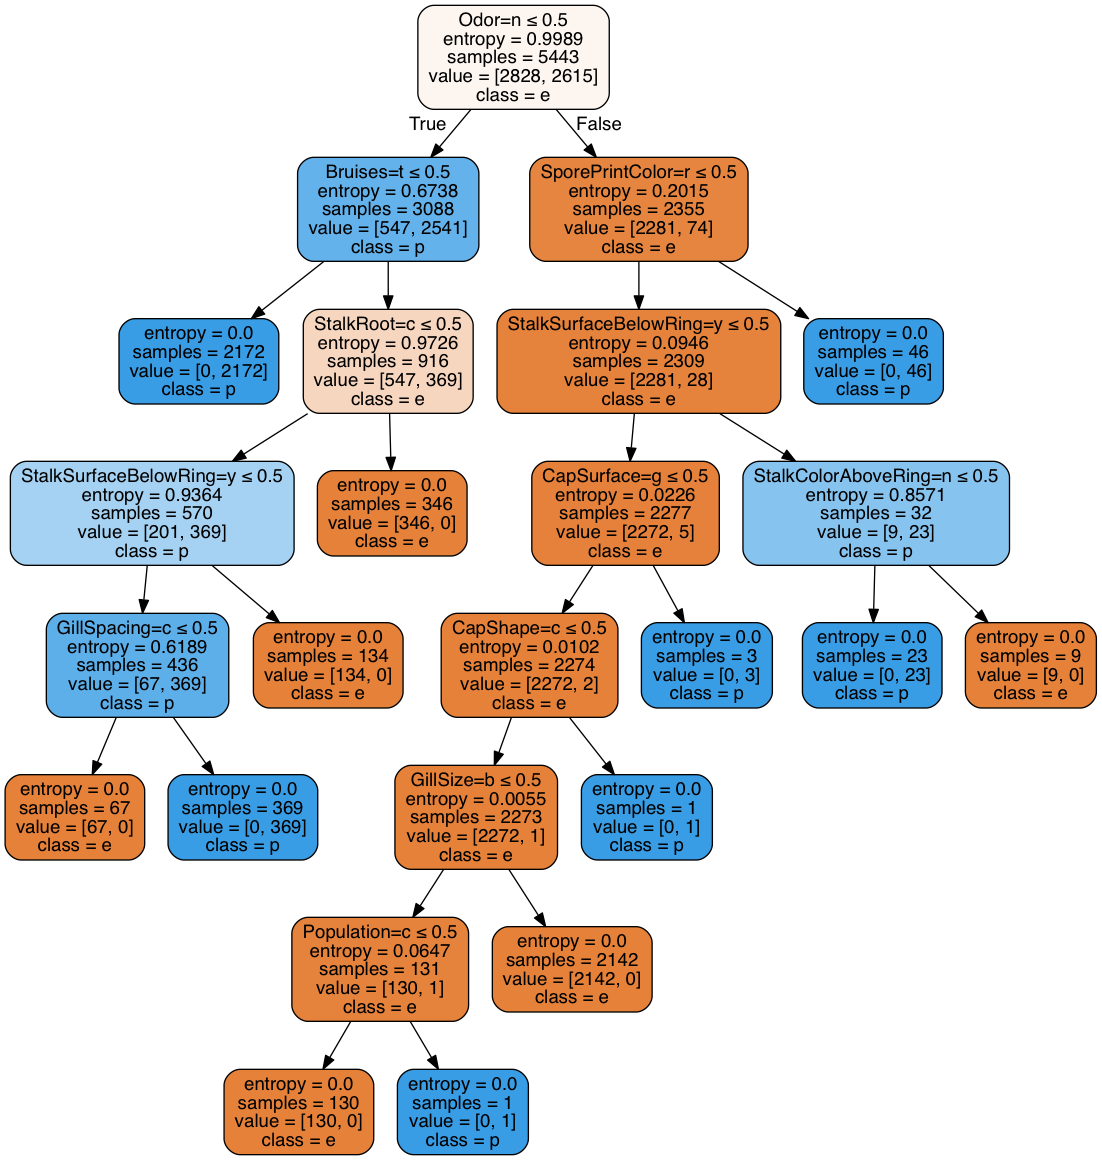

In [15]:
from IPython.display import Image, display
from sklearn.externals.six import StringIO
import pydot 

dot_data = StringIO() 
tree.export_graphviz(dtree, out_file=dot_data,  
                         feature_names=attr_encoder.feature_names_,  
                         class_names=label_encoder.classes_,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))


## Question 2: Decision Tree Cross-Validation (20 points)
One of the issues we've discussed is that a single train-test split can often provide a misleading view of the error  of our approach. Ideally, we want to look at how our method performs across many different settings. To understand this process, let's perform cross-validation on the decision trees.
1.   Split the decision tree data into four folds, allocating 2 for training, 1 for validation and 1 for testing. Set the `random_state` parameter to  `20160121` in the cross-validation split so that you get the same results as other students. For each cross-validation fold, train a decision tree (setting `random_state` to `20160121` again):
   * where the `max_depth` parameter varies from 1 to 6. 
   * where the `max_leaf_nodes` ranges from 5 to 12
   * where the `criterion` is gini
   * where the `min_samples_leaf` has values 2, 5, and 50
   
   In each case, compute the error on the validation set. What trend do you observe for each of these parameter settings?
4.   Using the parameters that had the best validation set performance across the folds, learn a decision tree using the training and validation data together. 
   * Report the error, F1, precision, recall, and accuracy for each fold, as well as the mean F1, precision, recall, and accuracy across folds.  
   * Visualize each of the four trees. Are the trees the same?


<h1> Question 2 Answers </h1>

<p>1. The trend is that the the higher the parameter number, the more accurate the prediction will be. So for max_leaf_nodes for example, the higher the value the more accurate the data. 
Also the accuracy plateaus at a certain parameter setting, after which there's no increases in accuracy. 
Again for the max_leaf_nodes, after max_leaf_nodes of 9, there's no increase in accuracy if the max_leaf_nodes go up to 12</p>

<p> See cell below for part 2 </p>


In [16]:
# Question 1 code

kfolds = cross_validation.KFold(8124, n_folds=4, shuffle=True, random_state=20160121)
np.set_printoptions(threshold='nan')

all_attributes = {
    'max_depth': {1, 2, 3, 4, 5, 6},
    'max_leaf_nodes': {5, 6, 7, 8, 9, 10, 11, 12},
    'criterion': {'gini'},
    'min_samples_leaf': {2, 5, 50}}

fold = 0
for train_total, test in kfolds:
    fold += 1
    print "Fold : " + str(fold)
    size = len(train_total)
    train = train_total[:2*(size / 3)]
    validation = train_total[2*(size/3):]
        
    mushroom_training_fold = pd.DataFrame(mushroom_attrs_encoded).iloc[train]
    mushroom_training_labels_fold = pd.DataFrame(mushroom_labels_encoded).iloc[train]
#   -----------------------  
    mushroom_validation_fold = pd.DataFrame(mushroom_attrs_encoded).iloc[validation]
    mushroom_validation_labels_fold = mushroom_labels_encoded[validation]
    
    for attr in all_attributes.keys():
        for value in all_attributes[attr]:
            accuracy = 0
            if attr == 'max_depth':
                dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', max_depth = value)

            elif attr == 'max_leaf_nodes':
                dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', max_leaf_nodes = value)

            elif attr == 'min_samples_leaf':
                dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', min_samples_leaf = value)
            
            elif attr == 'criterion':
                dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini')

            dtree.fit(mushroom_training_fold, mushroom_training_labels_fold);
            mushroom_predictions_fold = dtree.predict(mushroom_validation_fold);
            error = 1 - dtree.score(mushroom_validation_fold, mushroom_validation_labels_fold)              
            print attr +  ", Val: " + str(value) + \
                " Error: " + str(error)
            
        print "\n"


Fold : 1
max_leaf_nodes, Val: 5 Error: 0.44854751354
max_leaf_nodes, Val: 6 Error: 0.0413589364845
max_leaf_nodes, Val: 7 Error: 0.0221565731167
max_leaf_nodes, Val: 8 Error: 0.0167405219104
max_leaf_nodes, Val: 9 Error: 0.0157557853274
max_leaf_nodes, Val: 10 Error: 0.0157557853274
max_leaf_nodes, Val: 11 Error: 0.0157557853274
max_leaf_nodes, Val: 12 Error: 0.0157557853274


criterion, Val: gini Error: 0.0157557853274


max_depth, Val: 1 Error: 0.44854751354
max_depth, Val: 2 Error: 0.0556376169375
max_depth, Val: 3 Error: 0.0221565731167
max_depth, Val: 4 Error: 0.423929098966
max_depth, Val: 5 Error: 0.0157557853274
max_depth, Val: 6 Error: 0.0157557853274


min_samples_leaf, Val: 50 Error: 0.44854751354
min_samples_leaf, Val: 2 Error: 0.0157557853274
min_samples_leaf, Val: 5 Error: 0.0167405219104


Fold : 2
max_leaf_nodes, Val: 5 Error: 0.442146725751
max_leaf_nodes, Val: 6 Error: 0.0324963072378
max_leaf_nodes, Val: 7 Error: 0.0280649926145
max_leaf_nodes, Val: 8 Error: 0.011324

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1060
          1       1.00      1.00      1.00       971

avg / total       1.00      1.00      1.00      2031

Error: 0.00196947316593
Accuracy: 0.998030526834


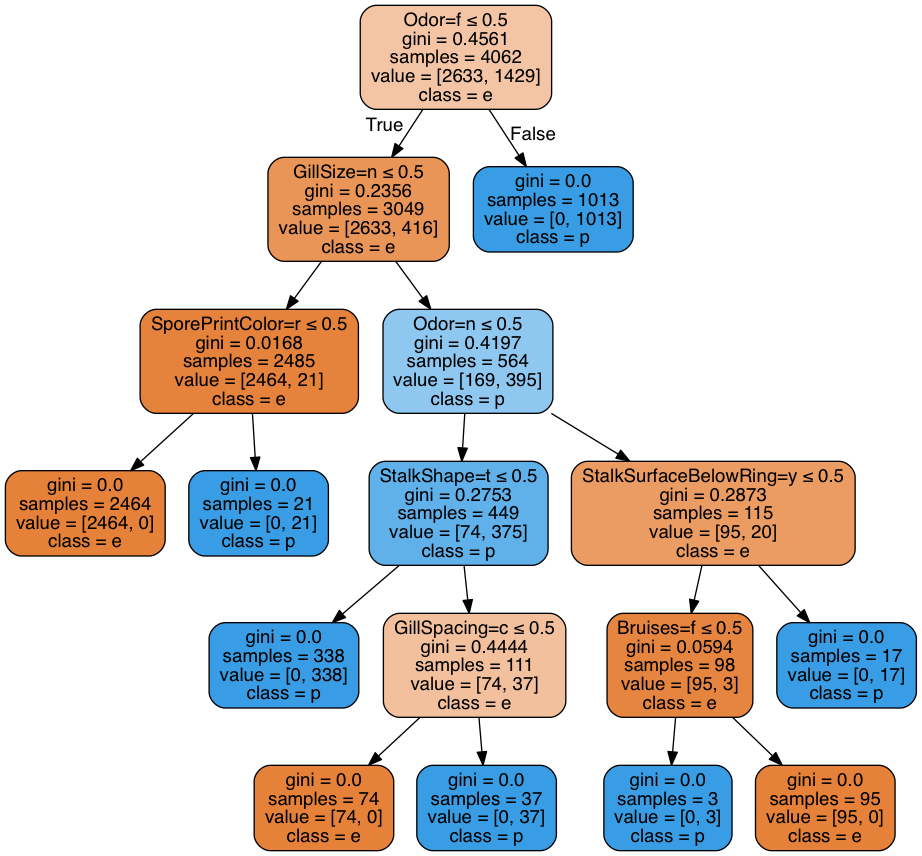

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1040
          1       1.00      0.99      0.99       991

avg / total       0.99      0.99      0.99      2031

Error: 0.00689315608075
Accuracy: 0.993106843919


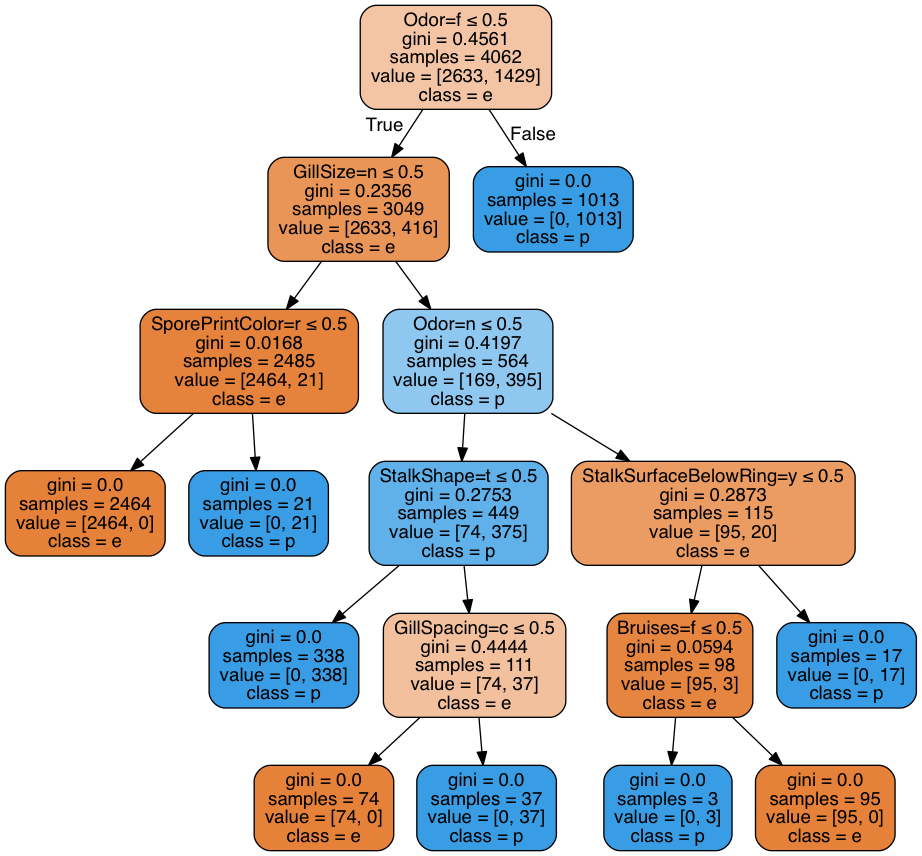

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1043
          1       1.00      0.99      1.00       988

avg / total       1.00      1.00      1.00      2031

Error: 0.00295420974889
Accuracy: 0.997045790251


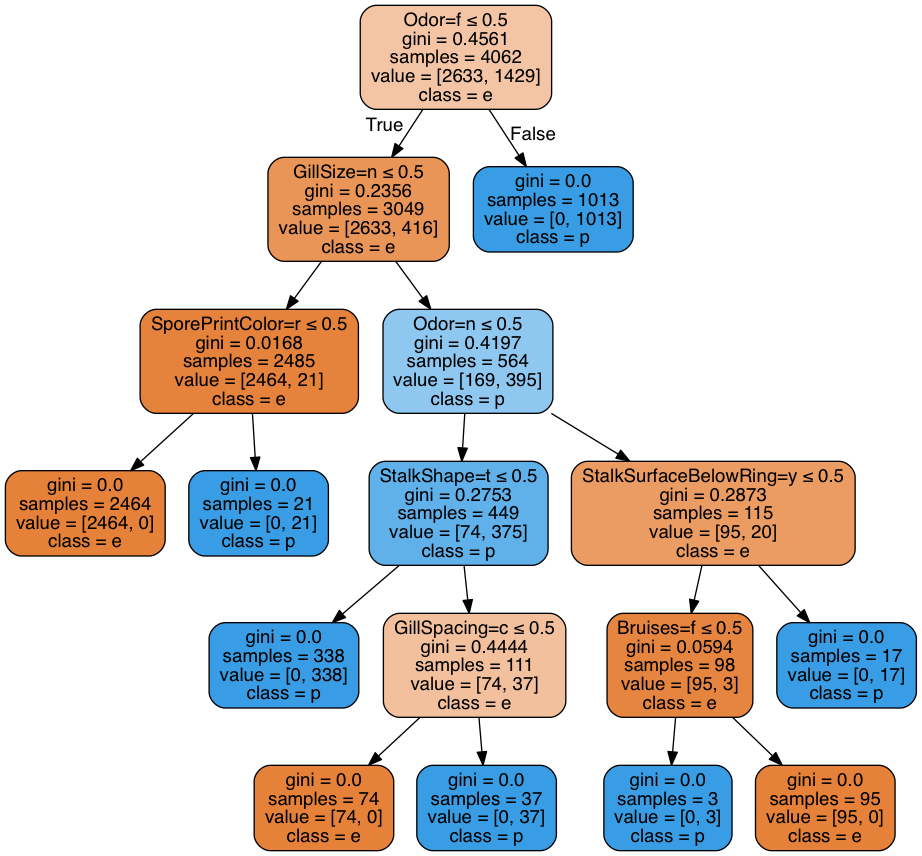

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1065
          1       1.00      0.99      0.99       966

avg / total       0.99      0.99      0.99      2031

Error: 0.00590841949778
Accuracy: 0.994091580502


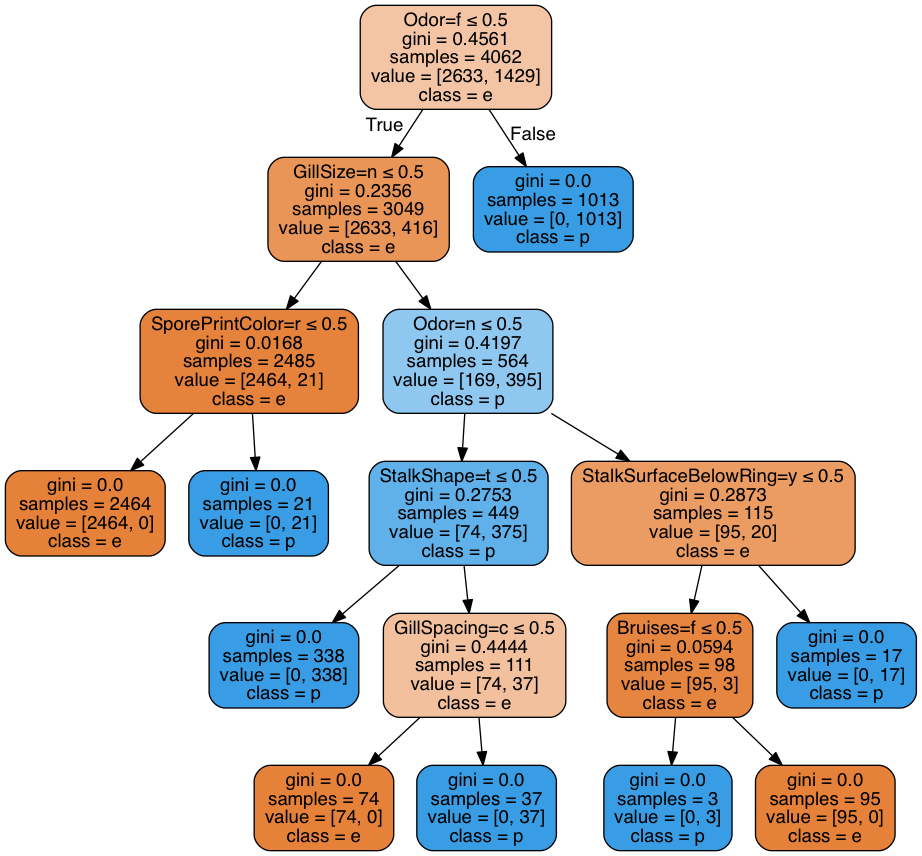

Mean error: 0.00443131462334 Mean accuracy: 0.995568685377


In [17]:
# Using the parameters that had the best validation set performance across the folds,
# learn a decision tree using the training and validation data together.
# Report the error, F1, precision, recall, and accuracy for each fold, as well as the mean F1, precision, recall, and accuracy across folds.
# Visualize each of the four trees. Are the trees the same?
from sklearn.metrics import classification_report

kfolds = cross_validation.KFold(8124, n_folds=4, shuffle=True, random_state=20160121)

mean_error = 0
mean_accuracy = 0

for train_total, test in kfolds:
#     print ("%s %s" % (train,test))
    
    mushroom_training_fold = pd.DataFrame(mushroom_attrs_encoded).iloc[train]
    mushroom_training_labels_fold = pd.DataFrame(mushroom_labels_encoded).iloc[train]
#   -----------------------  
    mushroom_test_fold = pd.DataFrame(mushroom_attrs_encoded).iloc[test]
    mushroom_test_labels_fold = mushroom_labels_encoded[test]
    
    dtree = tree.DecisionTreeClassifier(random_state=20160121, max_depth = 5, max_leaf_nodes = 9, min_samples_leaf = 2)
    
    dtree.fit(mushroom_training_fold, mushroom_training_labels_fold);
    mushroom_predictions_fold = dtree.predict(mushroom_test_fold);
    
    accuracy = dtree.score(mushroom_test_fold, mushroom_test_labels_fold)
    mean_accuracy += accuracy
    
    error = 1 - accuracy
    mean_error += error
    
    print metrics.classification_report(mushroom_test_labels_fold, mushroom_predictions_fold)
    print "Error: " + str(error) + \
        "\nAccuracy: " + str(accuracy)
    dot_data = StringIO() 
    tree.export_graphviz(dtree, out_file=dot_data,  
                         feature_names=attr_encoder.feature_names_,  
                         class_names=label_encoder.classes_,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))
    
print "Mean error: " + str(mean_error/4) + " Mean accuracy: " + str(mean_accuracy/4)


## Decision Trees with Continuous Values: Forests and Flowers
The decision tree example above uses only nominal values and makes categorical decision tests. Decision trees also operate on continuous values by *discretization* - converting continuous attributes into intervals or nominal attributes. In this section, you'll look at how decision trees work on continuous values. You'll use the Iris dataset we saw in the last assignment. 

## Question 3: Decision Trees for Continuous Features (5 points)
1.  Generate a decision tree for the Iris dataset, use 10-fold cross-validation (with `random_state` set to `20160121`) and report the mean error across folds. 
2.  Generate a visualization of the tree trained using all of the data. 
3.  What is the resubstitution error of the classifier on all of the data? How does this compare with the error estimated using 10-fold cross-validation?

As a hint, the code for this question is very similar to what's available in the scikit-learn documentation on [decision trees](http://scikit-learn.org/stable/modules/tree.html) and [cross-validated metrics](http://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics) 


<h1> Question 3 Answers </h1>

<p>1. Mean error across folds: 6%<p>
<p>2. See below</p>
<p>3. Resubstitution error is 0% , which is more optimistic than the 10 fold error we got of about 6%</p>

In [18]:
# Part 1 code
from sklearn.cross_validation import KFold
kfolds = cross_validation.KFold(150, n_folds=10, shuffle=True, random_state=20160121)
dtree = tree.DecisionTreeClassifier(random_state=20160121)

iris = datasets.load_iris()
mean_error = 0

for train, test in kfolds:
    iris_training = pd.DataFrame(iris.data[train])
    iris_training_labels = pd.DataFrame(iris.target[train])
#     -----------------------  
    iris_testing = pd.DataFrame(iris.data[test])
    iris_testing_labels = pd.DataFrame(iris.target[test])
    
    dtree.fit(iris_training, iris_training_labels)
    accuracy = dtree.score(iris_testing, iris_testing_labels)
    error = 1 - accuracy
    mean_error += error

print "Mean error: "  + (str(mean_error / 10))

Mean error: 0.06


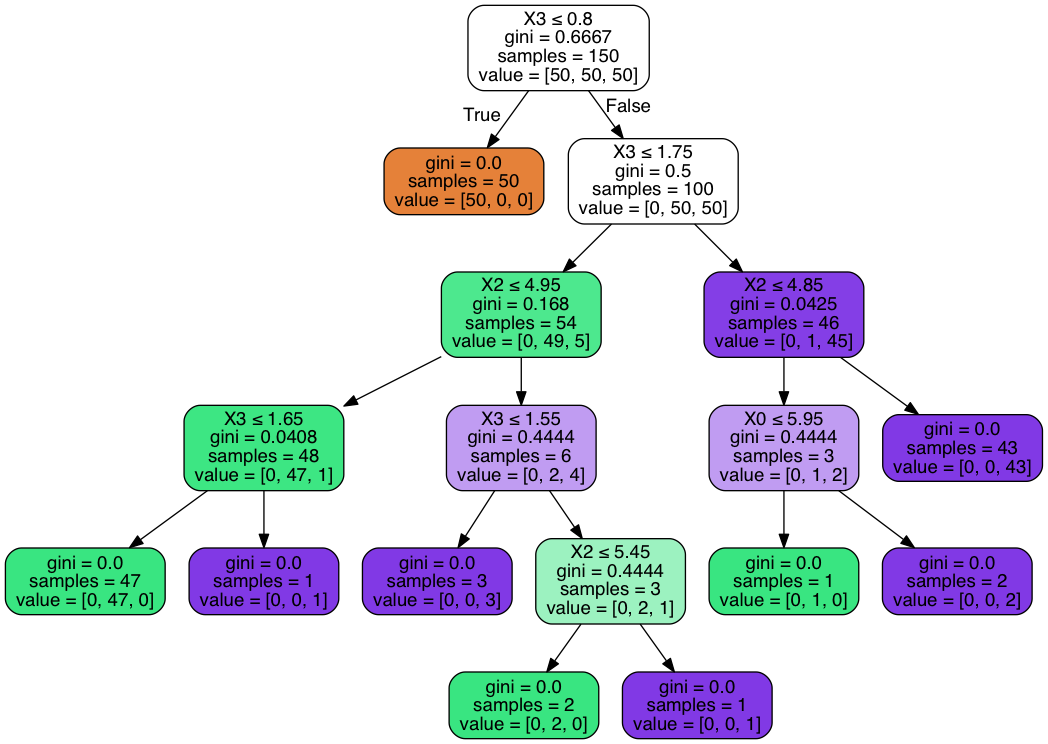

Resubstitution error: 1.0


In [19]:
# Part 2 code
dtree = tree.DecisionTreeClassifier(random_state=20160121)

iris_training = iris.data
iris_training_labels = iris.target

dtree.fit(iris_training, iris_training_labels)


dot_data = StringIO() 
tree.export_graphviz(dtree, out_file=dot_data,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))
    
accuracy = dtree.score(iris_training, iris_training_labels)
print "Resubstitution error: " + str(accuracy)

## Random Forests
One *extremely* popular approach in machine learning is the [Random Forest](https://en.wikipedia.org/wiki/Random_forest) and more complex successors such as Gradient Boosted Decision Trees. 
The Random Forest is an example of an ensemble method, where you combine multiple, simple classifiers to get a more robust result than one, complicated classifier. The basic idea behind a random forest is to create multiple samples of the data and attributes and learn a different decision tree on each of these samples. Then, each decision tree gets a vote on the final classification of an instance, and the majority wins.

Read more about [Random Forests](http://scikit-learn.org/stable/modules/ensemble.html#forest) and take a look at the [random forest documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) You can create random forests with syntax very similar to a decision tree. 

## Question 4: Seeing the Forests for the Trees (15 points)
1.   Choose a new dataset (one that hasn't been used in the assignments yet) with a categorical label. Load the data with meaningful column names and pre-process the data to remove any missing values.

Good places to look for data are [Data.gov](http://www.data.gov/), [UCI Machine Learning Dataset Repository](http://archive.ics.uci.edu/ml/index.html), [Data SF](http://datasf.org/), or [mldata.org](http://mldata.org/). scikit-learn will load datasets downloaded from mldata.org directly (see the [datasets documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)), but you'll need to register with the site before you can download data.

2.  Split the data into training and test folds, or use cross-validation folds/scoring.

3.  Train both a decision tree classifier and a random forest classifier on your training data. It may be useful to set the maximum depth or maximum leaf nodes or minimum leaf samples for the random forest. Report the test error for both classifiers. Which performs better? Perform a t-test to decide whether the means differ significantly. Is the performance difference between the classifiers significant?

4.  Train both the decision tree and the random forest using all of the labeled data and include a visualization of the single decision tree and the trees in the random forest. (Hint: you can access the trees in your forest by iterating over the variable estimators\_ For example, if your RandomForestClassifier is called `forest`, you could write:

        for dtree in forest.estimators_:
            display(Image(...))


<h1> Question 4 Answers </h1>
<p>1. see below </p>
<p>2. t-statistic=-1.4305633952771812, pvalue=0.15961920234647561) 
      The tree classifier performs better but based on the t statistic, the difference is not significant
<p>3. 


In [20]:
## Preliminaries

#Show plots in the notebook
%matplotlib inline

# To start we import some prerequisites
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib2

In [21]:
#Let's download the data using the link on the page above:
wine_data = urllib2.urlopen("http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data")
#we can use a module called pandas to parse and manipulate this data
wine_dataset = pd.read_csv(wine_data, quotechar='"', skipinitialspace=True)

# By default, only a few columns are shown. Setting this option allows us to see all the columns
pd.set_option('display.max_columns', None) 
# Let's look at the first ten rows

wine_data = wine_dataset.ix[:,1:14]
wine_labels = wine_dataset.ix[:,0]

In [22]:
[wine_train_data, wine_test_data,  wine_train_labels, wine_test_labels] = cross_validation.train_test_split(wine_data, wine_labels, test_size=0.25, random_state=20160121)

# Decision tree train
dtree = tree.DecisionTreeClassifier(random_state=20160121)
dtree.fit(wine_train_data, wine_train_labels);
dt_predictions = dtree.predict(wine_test_data);

# The easy way to do this is using the score function:
dt_error = 1 - dtree.score(wine_test_data, wine_test_labels)
print "Error (via score):", dt_error


Error (via score): 0.0


In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=1, random_state=20160121)
clf = clf.fit(wine_train_data, wine_train_labels)
clf_predictions = clf.predict(wine_test_data)

clf_error = 1 - clf.score(wine_test_data, wine_test_labels)
print "Error (via score):", clf_error

Error (via score): 0.0222222222222


In [24]:
from scipy import stats

# Which performs better? They're both the same error 
# Is the performance difference between the classifiers significant?
# They are not statistically different
stats.ttest_rel(dt_predictions, clf_predictions)

Ttest_relResult(statistic=-1.0, pvalue=0.32277847875430932)

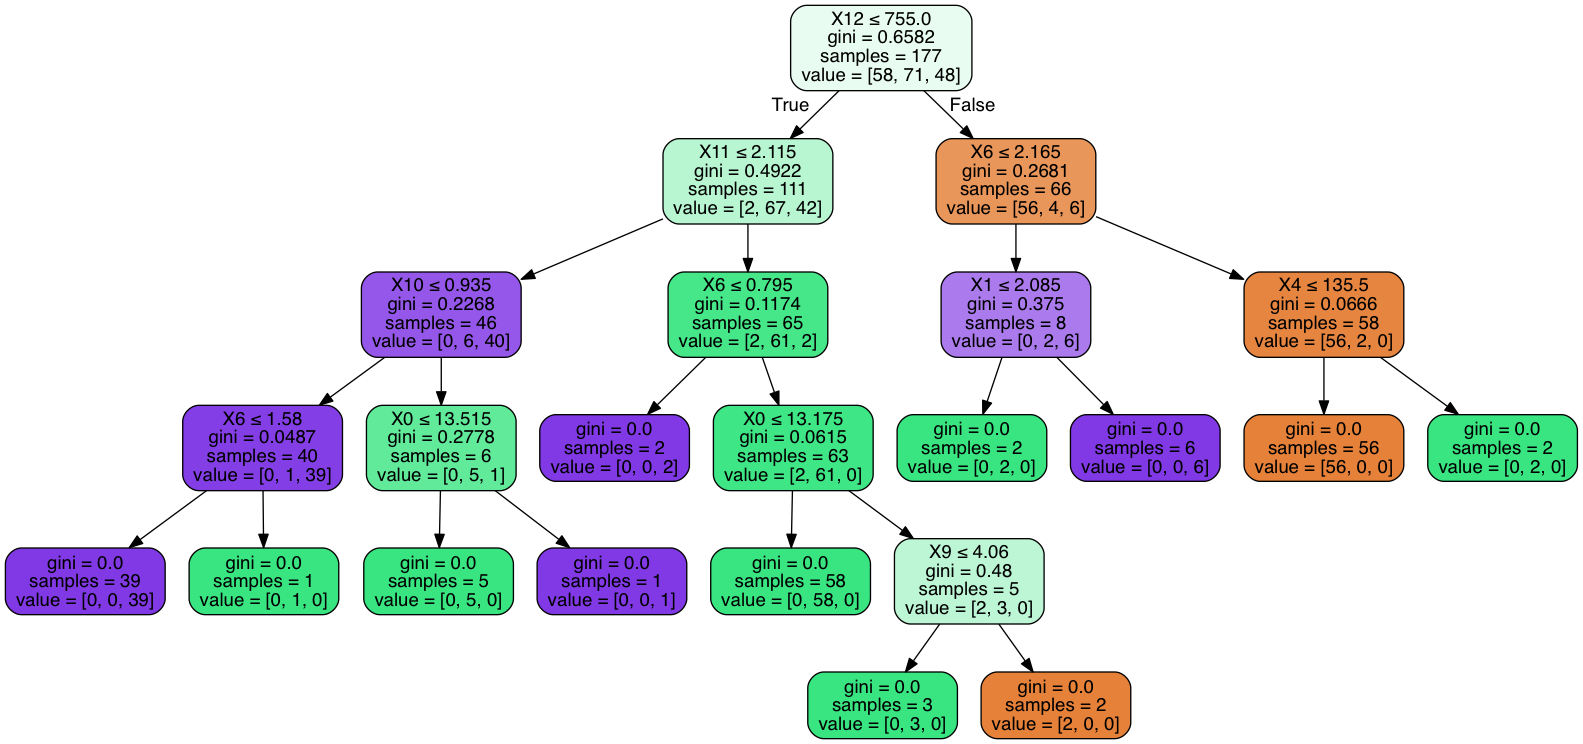

In [25]:
# Decision tree train
dtree = tree.DecisionTreeClassifier(random_state=20160121)
dtree.fit(wine_data, wine_labels);

dot_data = StringIO() 
tree.export_graphviz(dtree, out_file=dot_data,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

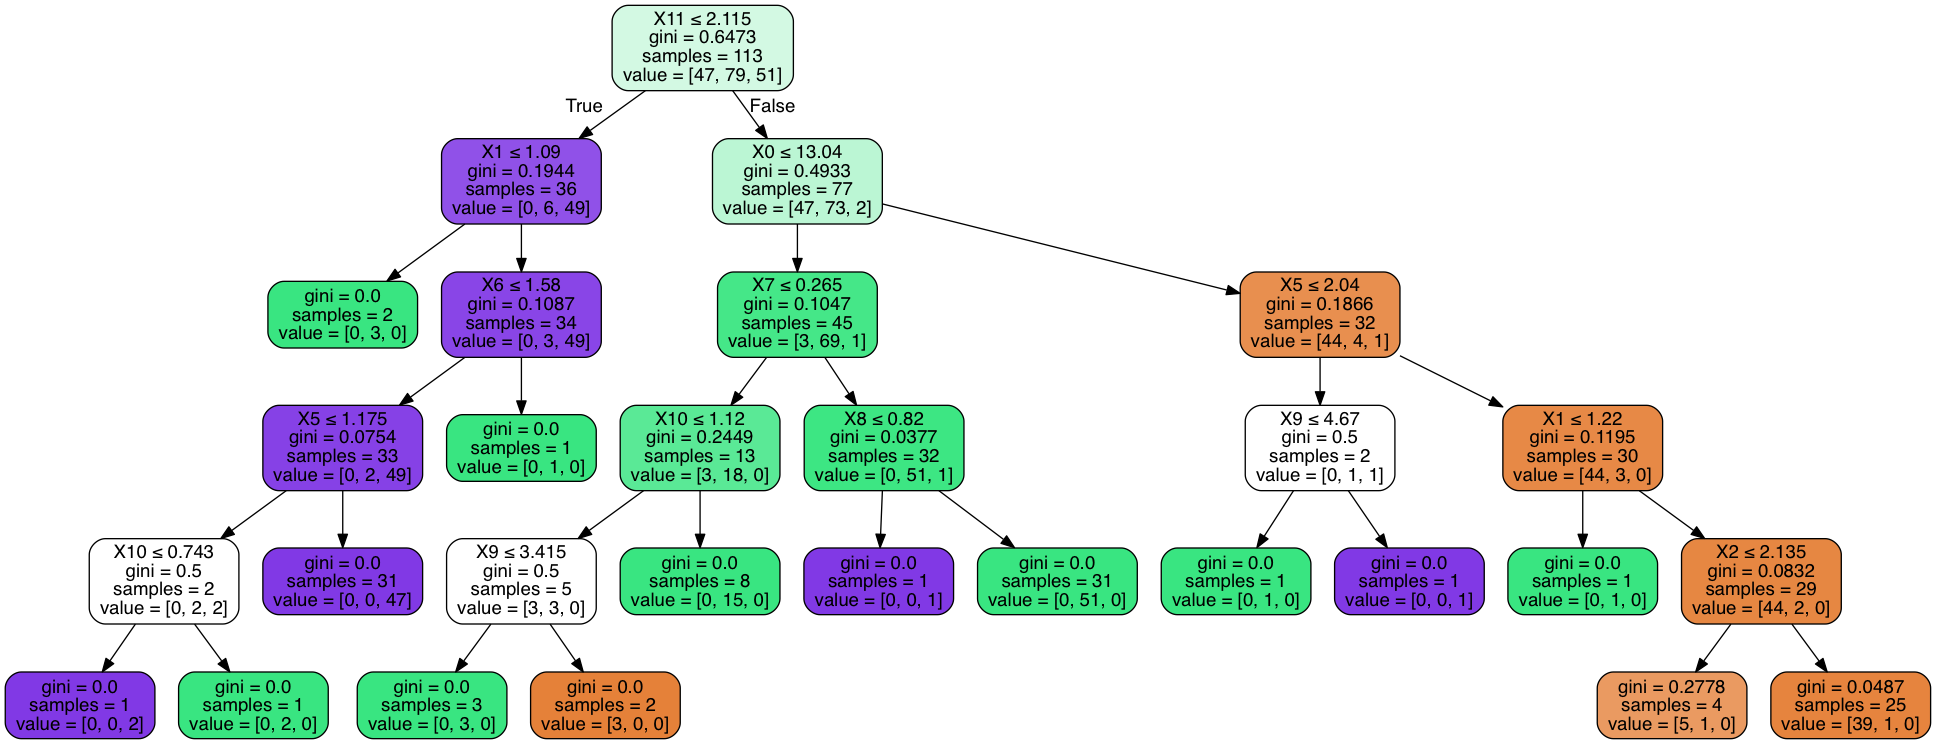

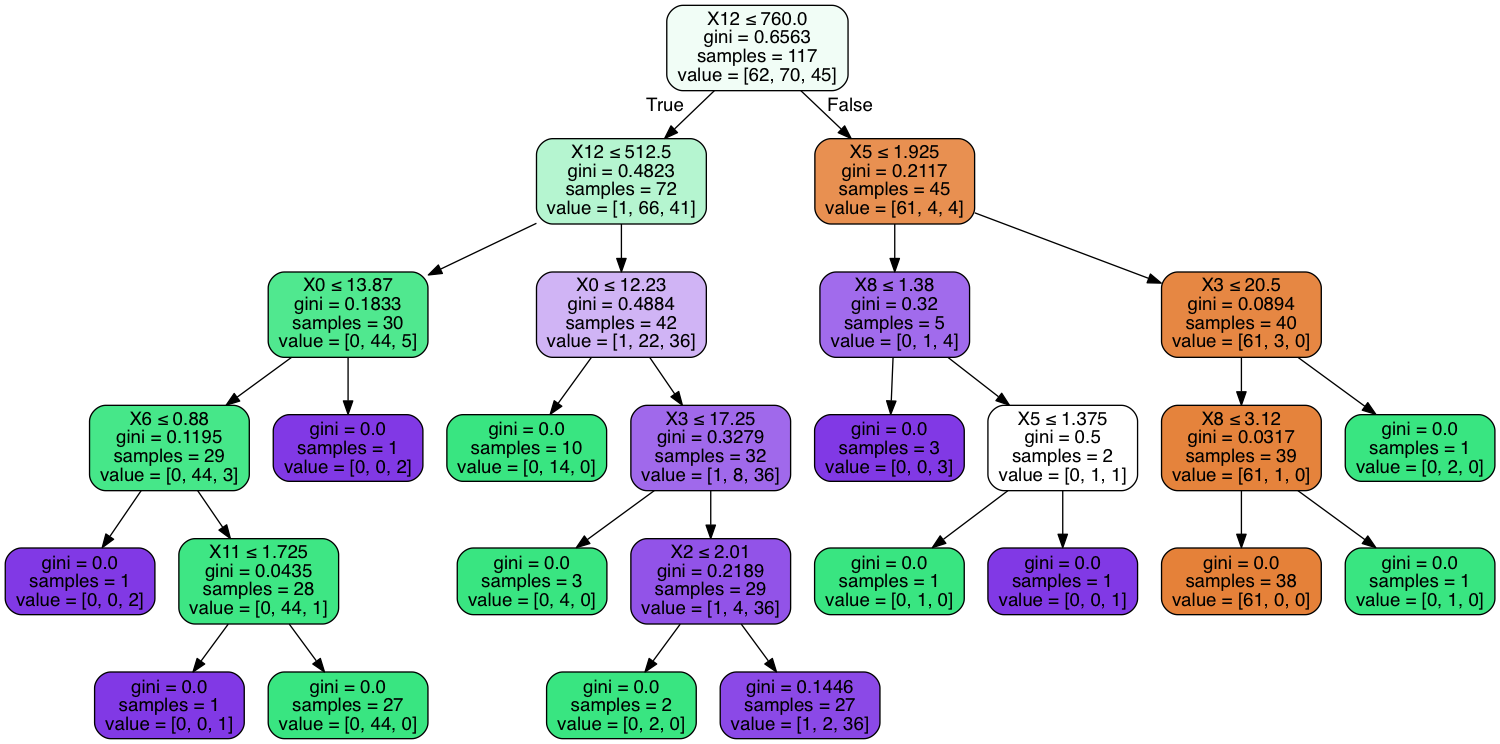

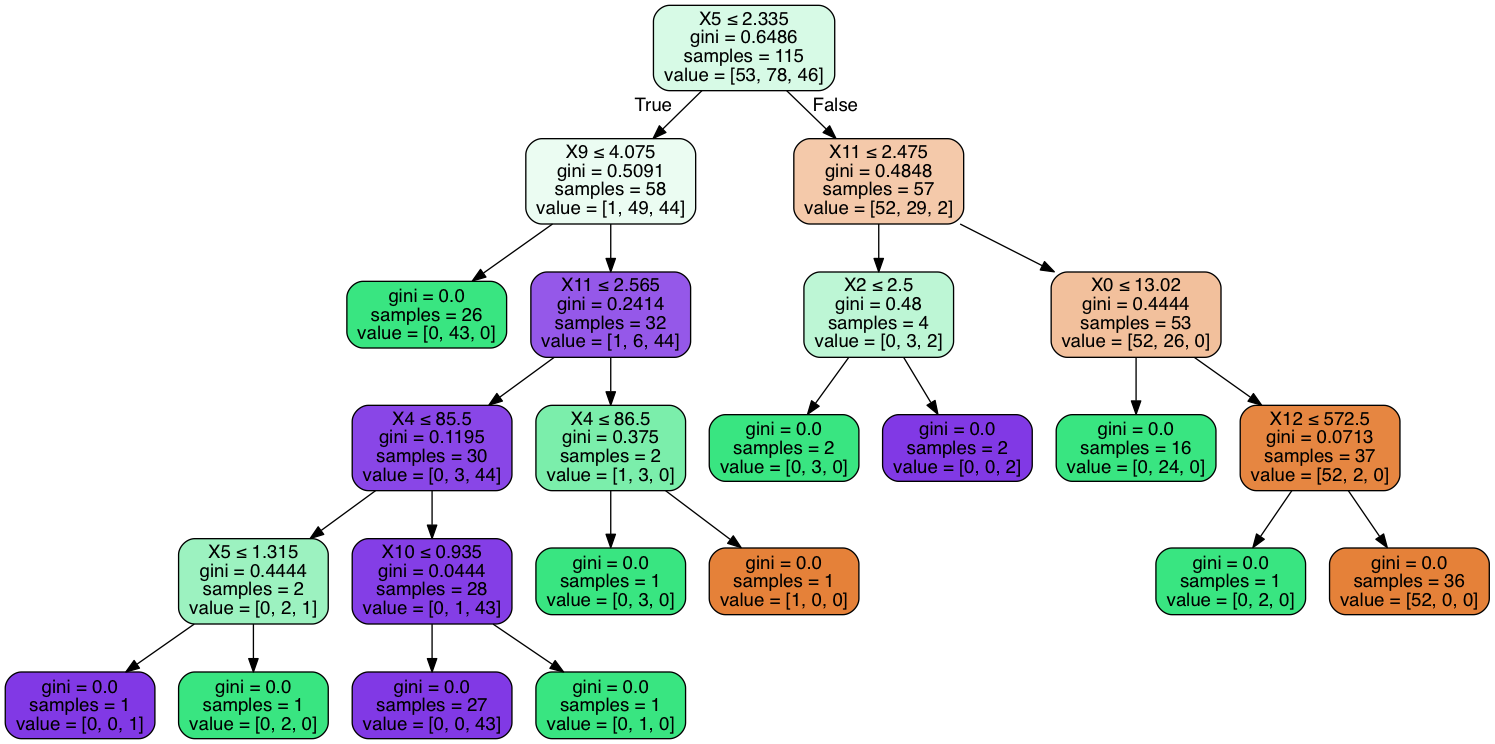

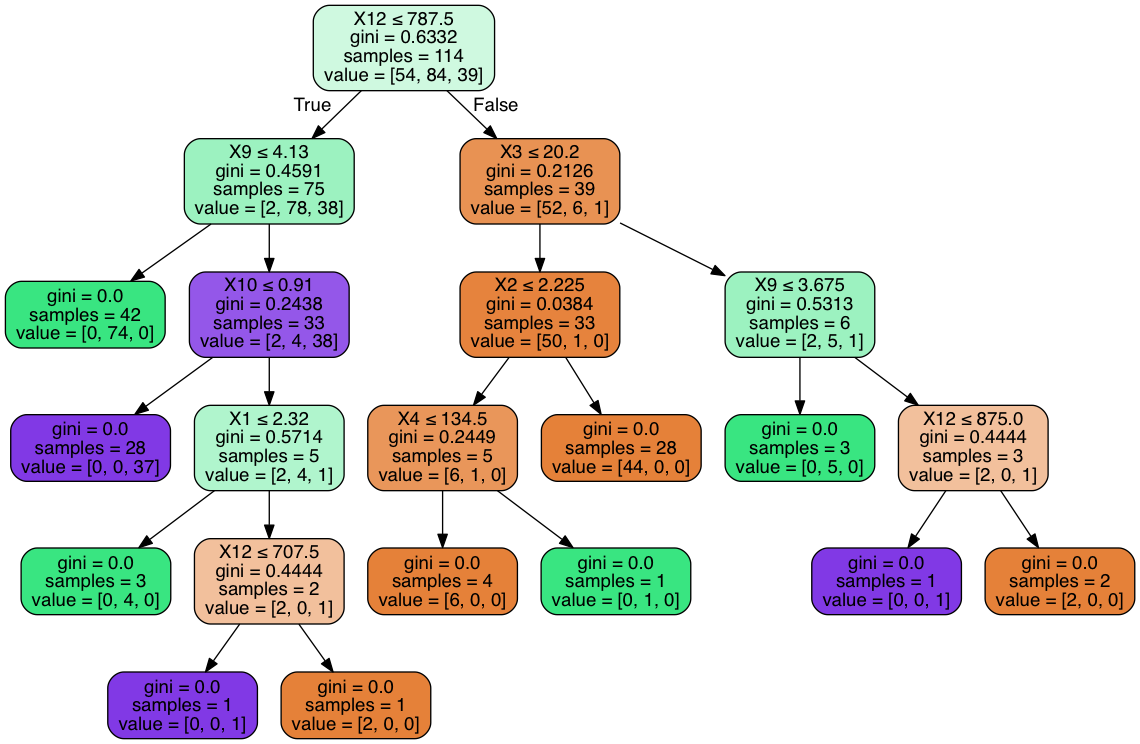

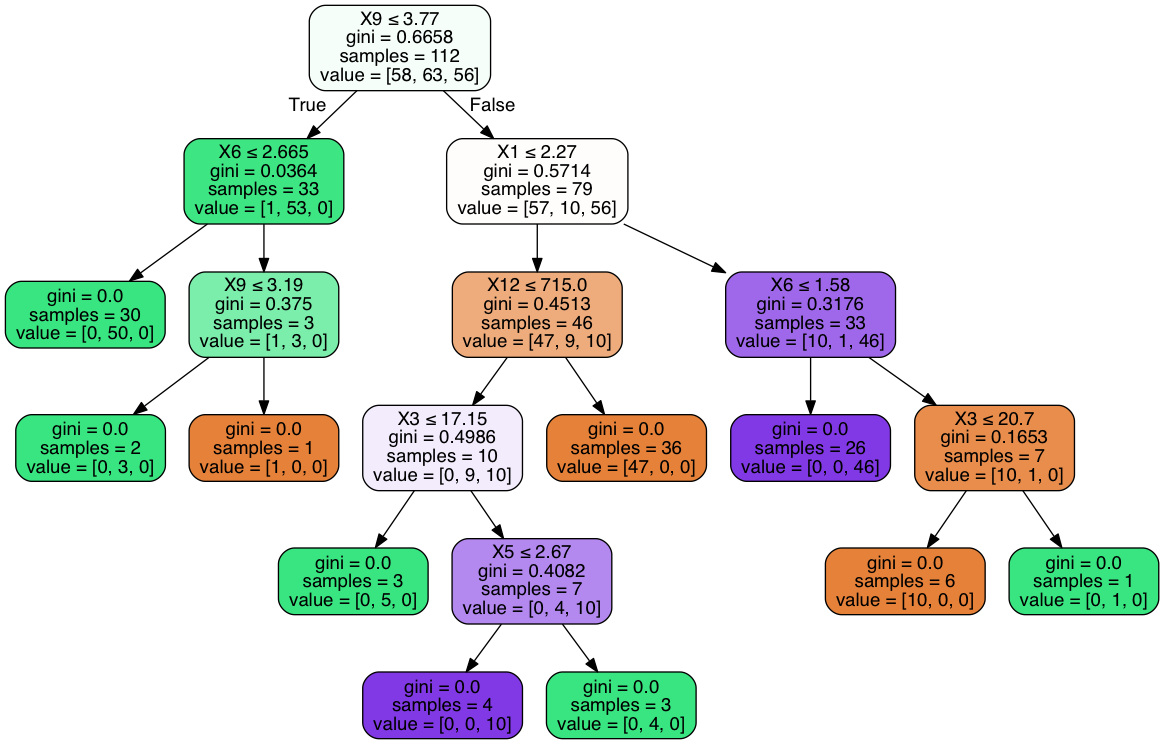

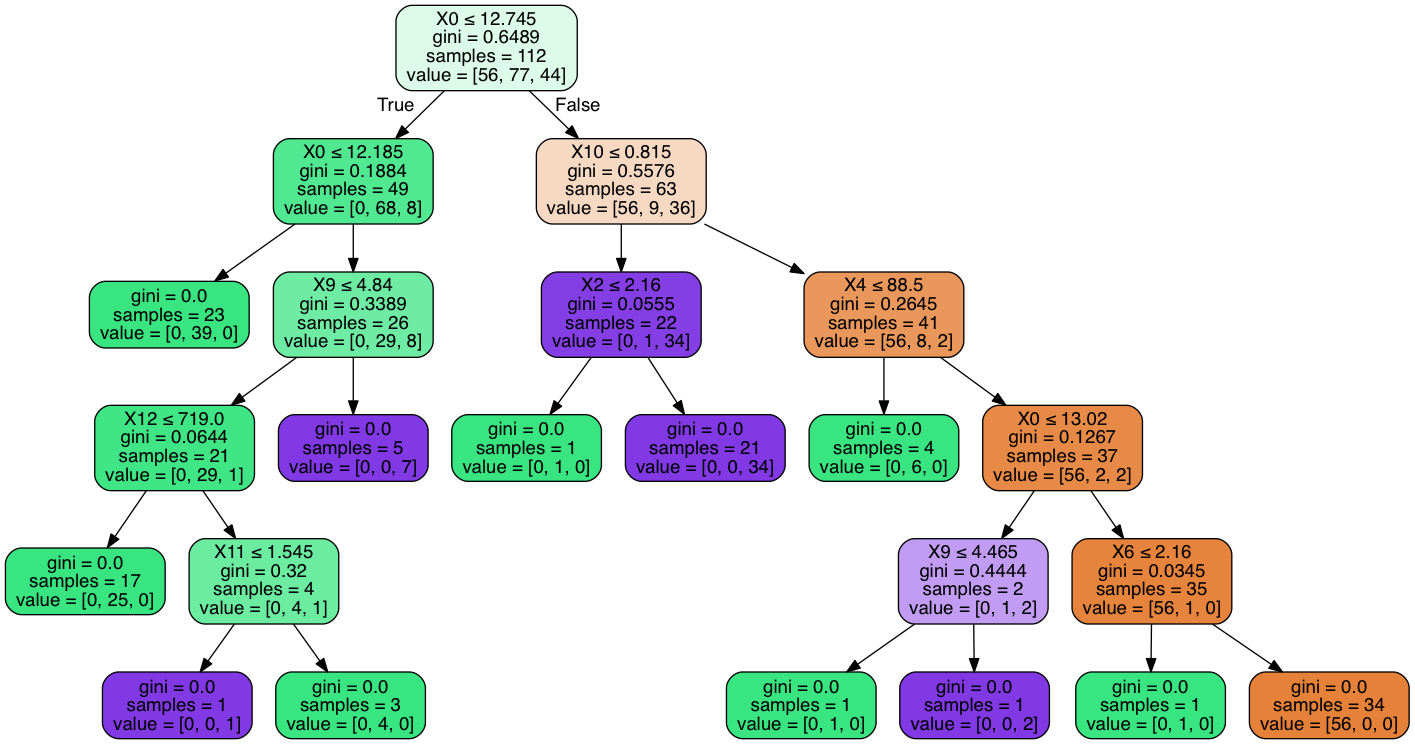

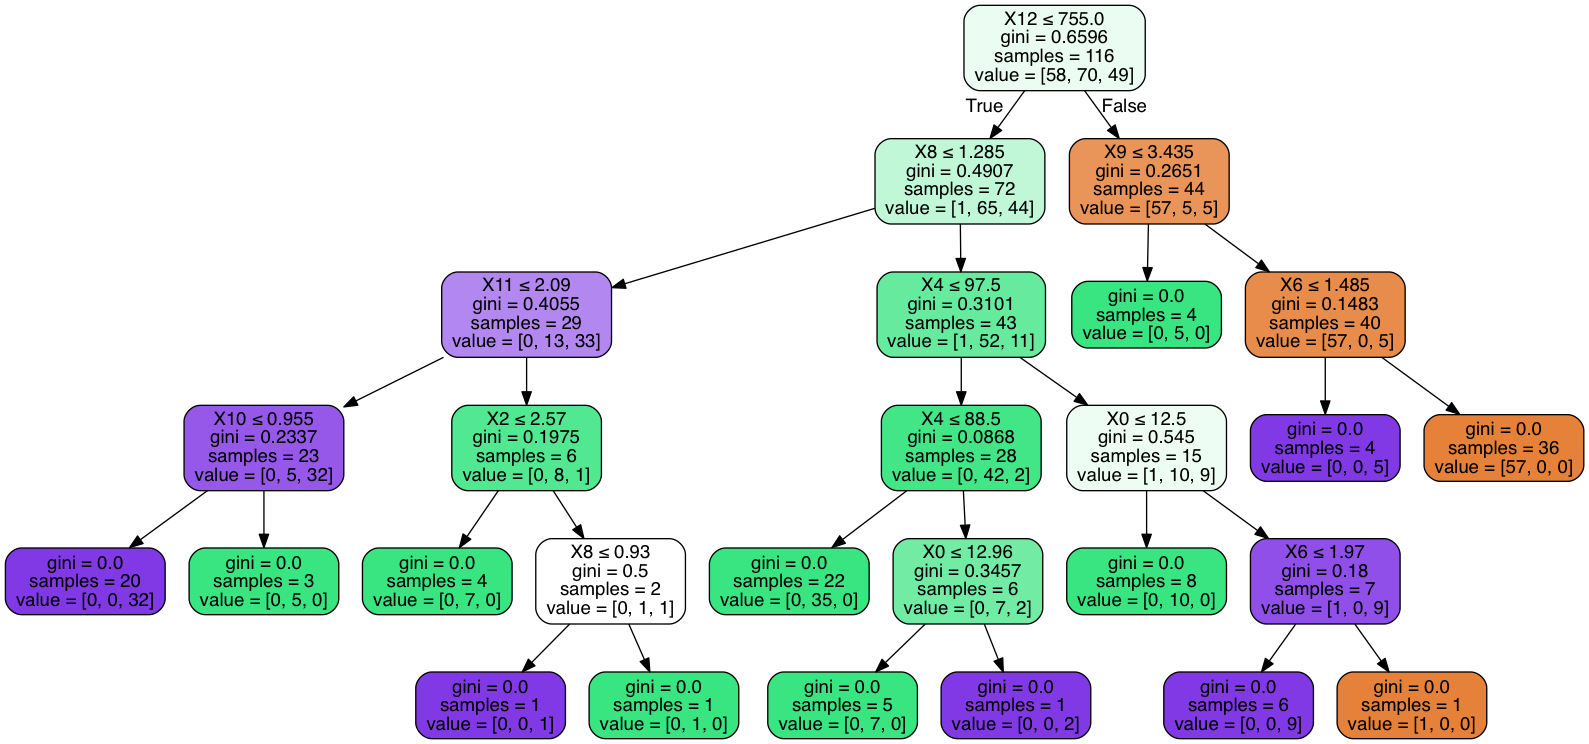

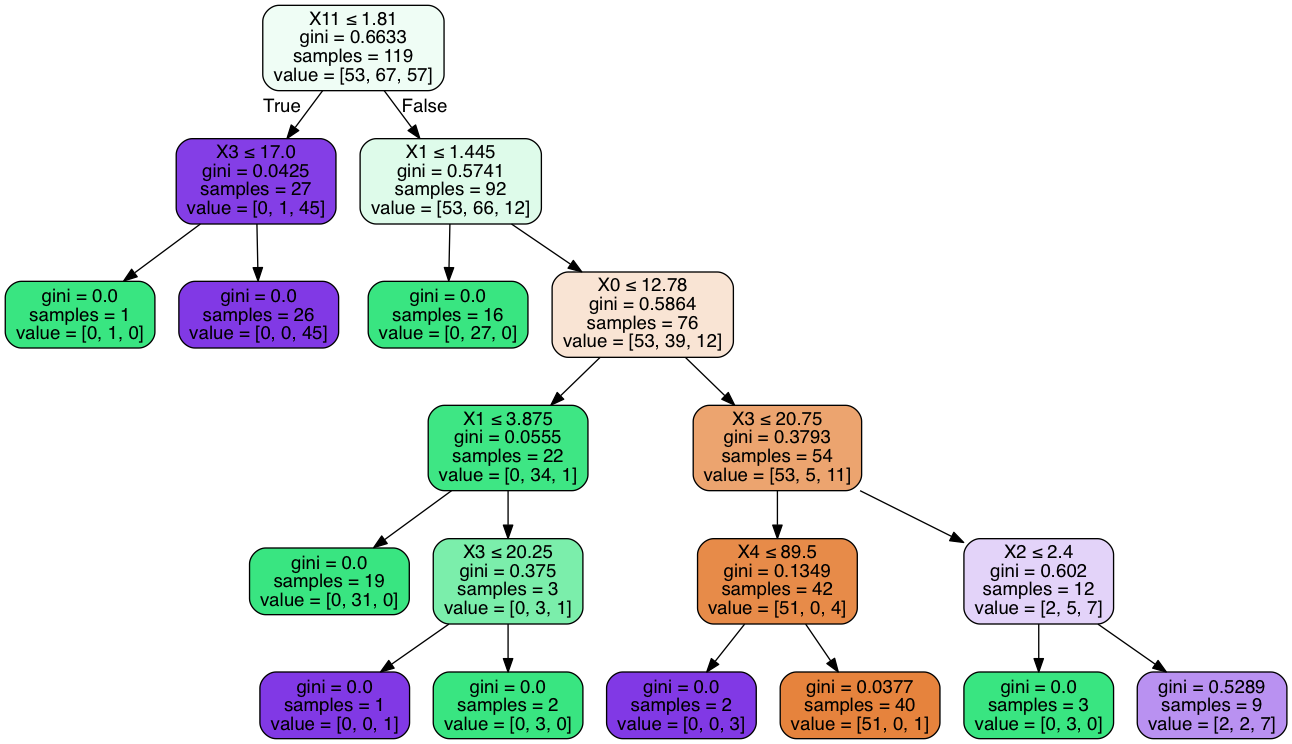

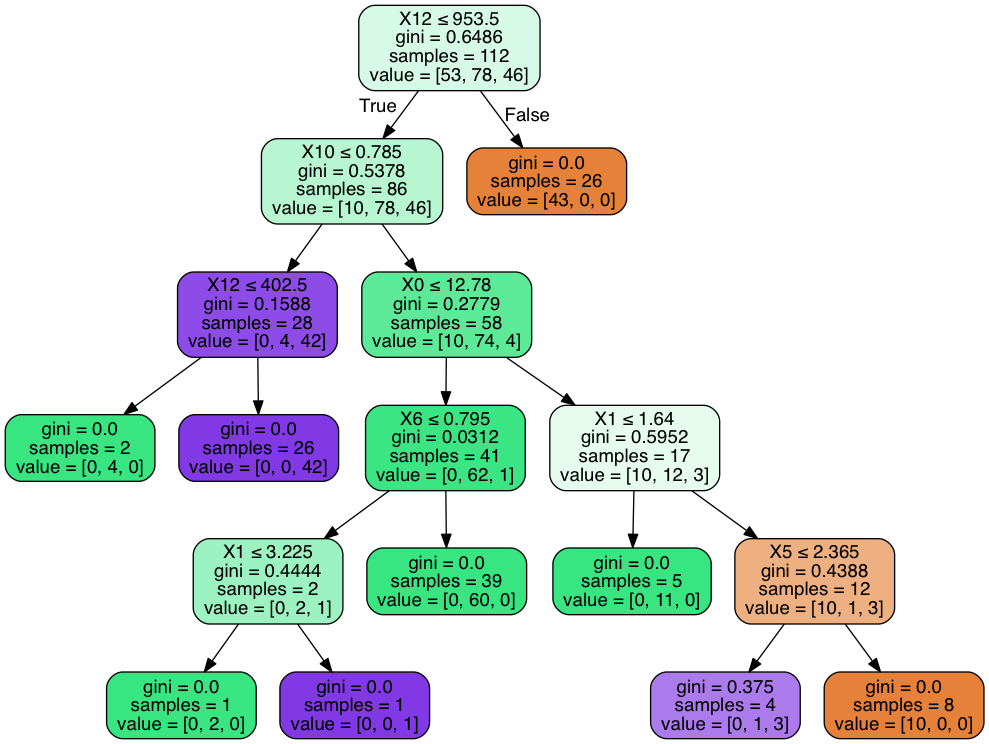

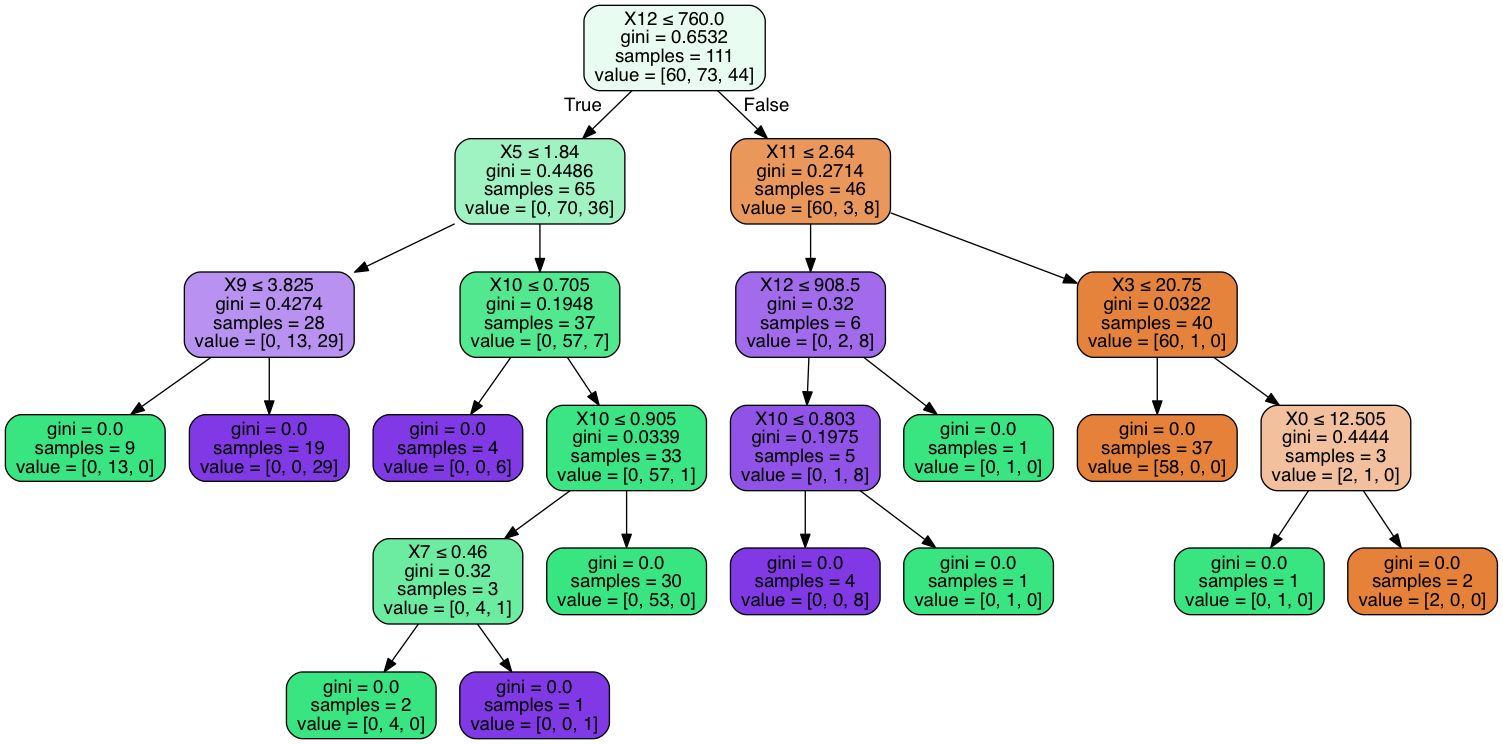

In [26]:
clf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=1, random_state=20160121)
clf = clf.fit(wine_data, wine_labels)

for dtree in clf.estimators_:

    dot_data = StringIO() 
    tree.export_graphviz(dtree, out_file=dot_data,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))